# MSBA 6420 - Preditive Analytics Project | Data Aggregation


The Home credit dataset contains multiple datasets which need to be aggregated to the *SK_ID_CURR* level, level of the application datasets.


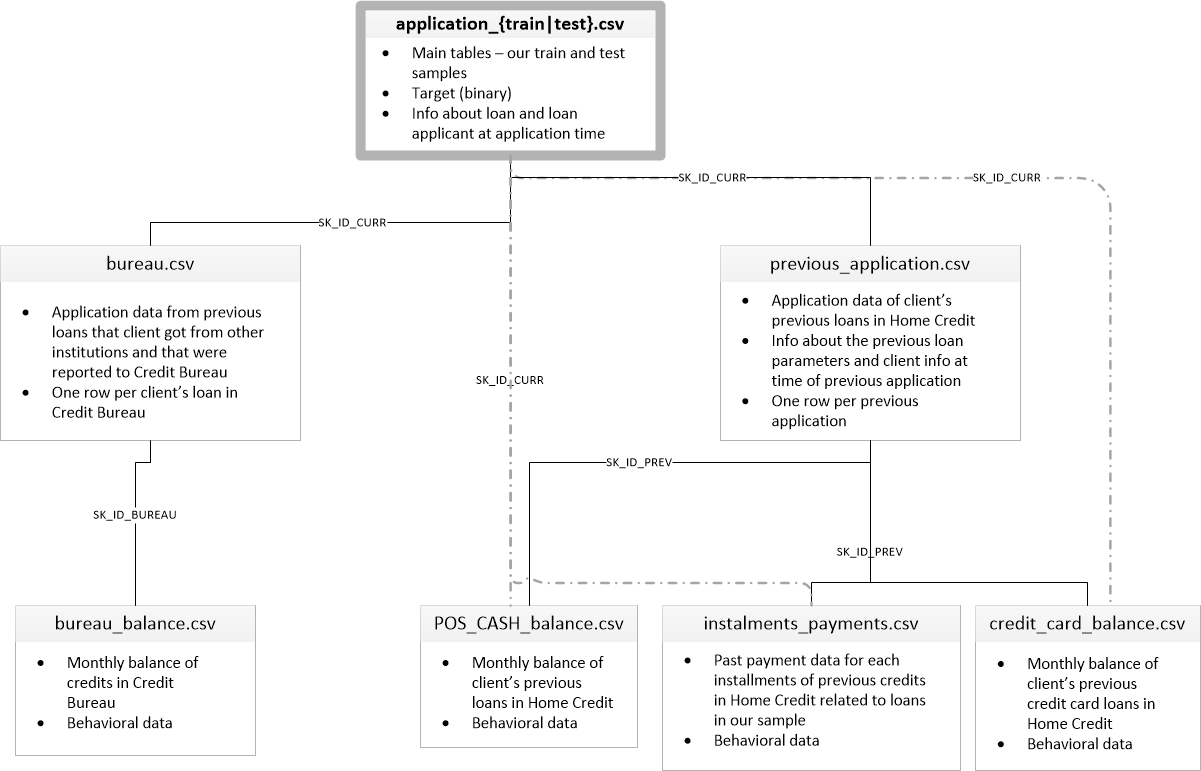

In [2]:
import pandas as pd
import numpy as np
import re
import os
import gc

## BUREAU AND BUREAU BALANCE

**BUREAU**  
>All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

**BUREAU BALANCE**
>Monthly balances of previous credits in Credit Bureau.This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [3]:
bureau = pd.read_csv(r'../input/home-credit-default-risk/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
bureau_balances = pd.read_csv(r'../input/home-credit-default-risk/bureau_balance.csv')
bureau_balances.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


**Merging the bureau data of each individual loans with the data for monthly status of dues for the loan**?

In [5]:
merged = pd.merge(bureau,bureau_balances,how='inner',on='SK_ID_BUREAU')

**For all the loans, the credit bureau sends an update every month, even for the loans which have been completed, status is 'C'. We only look at the history of loans when they were active.**

**For loans with status as 'X' or Unknown, we assume that the loan does not have any DPD and hence replace 'X' with 0. Status column is now converted into a ordinal numeric columns with 0<1<2<3<4<5 in terms of DPD**

In [6]:
merged = merged[merged['STATUS'] != "C"]
merged['STATUS'] = merged['STATUS'].replace({'X':0}).astype(int)

**For all the loans in the bureau data, we count the number of months for each status code of DPD**

In [7]:
pivoted_balance = merged.groupby(['SK_ID_CURR','SK_ID_BUREAU','CREDIT_ACTIVE','STATUS'],as_index=False).size().pivot(index=['SK_ID_CURR','SK_ID_BUREAU','CREDIT_ACTIVE'],columns='STATUS',values='size').reset_index().fillna(0)
pivoted_balance.head()

STATUS,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,0,1,2,3,4,5
0,100001,5896630,Closed,10.0,0.0,0.0,0.0,0.0,0.0
1,100001,5896631,Closed,1.0,0.0,0.0,0.0,0.0,0.0
2,100001,5896632,Closed,11.0,0.0,0.0,0.0,0.0,0.0
3,100001,5896633,Closed,8.0,0.0,0.0,0.0,0.0,0.0
4,100001,5896634,Active,18.0,1.0,0.0,0.0,0.0,0.0


**Total defaults** : Number of DPD months for a given credit  
**% Total defaults** : % of months with DPD for the credit  
**Average default months** : This is a weighted aggregation of the status column, signifying larger DPD with a greater value  

In [8]:
pivoted_balance['total_defaults'] = pivoted_balance.iloc[:,3:].sum(axis=1)
pivoted_balance['%_total_defaults'] = pivoted_balance['total_defaults']*100 / (pivoted_balance['total_defaults'] + pivoted_balance[0])
pivoted_balance['avg_default_months'] = ((pivoted_balance[0]*0 + pivoted_balance[1]*1 + pivoted_balance[2]*2 + pivoted_balance[3]*3 + pivoted_balance[4]*4 + pivoted_balance[5]*5)/(pivoted_balance[0] + pivoted_balance[1] + pivoted_balance[2] + pivoted_balance[3] + pivoted_balance[4] + pivoted_balance[5])).fillna(0)
pivoted_balance.head()

STATUS,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,0,1,2,3,4,5,total_defaults,%_total_defaults,avg_default_months
0,100001,5896630,Closed,10.0,0.0,0.0,0.0,0.0,0.0,10.0,50.000000,0.000000
1,100001,5896631,Closed,1.0,0.0,0.0,0.0,0.0,0.0,1.0,50.000000,0.000000
2,100001,5896632,Closed,11.0,0.0,0.0,0.0,0.0,0.0,11.0,50.000000,0.000000
3,100001,5896633,Closed,8.0,0.0,0.0,0.0,0.0,0.0,8.0,50.000000,0.000000
4,100001,5896634,Active,18.0,1.0,0.0,0.0,0.0,0.0,19.0,51.351351,0.052632


**Aggregating the DPD columns at SK_ID_BUREAU (loan level) to SK_ID_CURR (customer level)**

In [9]:
bureau_balance_overall = pivoted_balance.drop(columns=['CREDIT_ACTIVE']).groupby(['SK_ID_CURR']).agg({
    0:['sum','max'],
    1:['sum','max'],
    2:['sum','max'],
    3:['sum','max'],
    4:['sum','max'],
    5:['sum','max'],
    'total_defaults':['sum','max',np.mean],
    '%_total_defaults':[np.mean,'max'],
    'avg_default_months':[np.median,'max']})

bureau_balance_overall.columns = bureau_balance_overall.columns.map(lambda x: str(x[0]) + '_' + str(x[1]))
bureau_balance_overall.reset_index(inplace=True)
bureau_balance_overall.head()

,SK_ID_CURR,0_sum,0_max,1_sum,1_max,2_sum,2_max,3_sum,3_max,4_sum,4_max,5_sum,5_max,total_defaults_sum,total_defaults_max,total_defaults_mean,%_total_defaults_mean,%_total_defaults_max,avg_default_months_median,avg_default_months_max
0,100001,61.0,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,19.0,8.857143,50.193050,51.351351,0.000000,0.052632
1,100002,60.0,19.0,27.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,20.0,10.875000,59.061772,66.666667,0.428571,0.500000
2,100005,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,8.0,5.333333,50.000000,50.000000,0.000000,0.000000
3,100010,20.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,10.0,10.000000,50.000000,50.000000,0.000000,0.000000
4,100013,120.0,40.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0,40.0,31.750000,51.724819,53.658537,0.062741,0.136364


**Aggregating the DPD data for active and closed credits to the SK_ID_CURR (customer) level**

In [10]:
bureau_balance_status = pivoted_balance.groupby(['SK_ID_CURR',"CREDIT_ACTIVE"]).agg({
    0:['sum','max'],
    1:['sum','max'],
    2:['sum','max'],
    3:['sum','max'],
    4:['sum','max'],
    5:['sum','max'],
    'total_defaults':['sum','max',np.mean],
    '%_total_defaults':[np.mean,'max'],
    'avg_default_months':[np.median,'max']})

bureau_balance_status.columns = bureau_balance_status.columns.map(lambda x: str(x[0]) + '_' + str(x[1]))
bureau_balance_status.reset_index(inplace=True)

bureau_balance_status = bureau_balance_status.pivot_table(index='SK_ID_CURR',columns='CREDIT_ACTIVE',fill_value=0)
bureau_balance_status.columns = bureau_balance_status.columns.map('_'.join)
bureau_balance_status.reset_index(inplace=True)
bureau_balance_status.head()

,SK_ID_CURR,%_total_defaults_max_Active,%_total_defaults_max_Bad debt,%_total_defaults_max_Closed,%_total_defaults_max_Sold,%_total_defaults_mean_Active,%_total_defaults_mean_Bad debt,%_total_defaults_mean_Closed,%_total_defaults_mean_Sold,0_max_Active,...,total_defaults_max_Closed,total_defaults_max_Sold,total_defaults_mean_Active,total_defaults_mean_Bad debt,total_defaults_mean_Closed,total_defaults_mean_Sold,total_defaults_sum_Active,total_defaults_sum_Bad debt,total_defaults_sum_Closed,total_defaults_sum_Sold
0,100001,51.351351,0.0,50.000000,0.0,50.450450,0.0,50.000000,0.0,18,...,11,0,10.666667,0,7.50,0.0,32,0,30,0
1,100002,63.636364,0.0,66.666667,0.0,56.818182,0.0,59.809635,0.0,8,...,20,0,9.000000,0,11.50,0.0,18,0,69,0
2,100005,50.000000,0.0,50.000000,0.0,50.000000,0.0,50.000000,0.0,5,...,8,0,4.000000,0,8.00,0.0,8,0,8,0
3,100010,50.000000,0.0,50.000000,0.0,50.000000,0.0,50.000000,0.0,10,...,10,0,10.000000,0,10.00,0.0,10,0,10,0
4,100013,0.000000,0.0,53.658537,0.0,0.000000,0.0,51.724819,0.0,0,...,40,0,0.000000,0,31.75,0.0,0,0,127,0


**Adding additional flags and columns to the data**
* **Loan Duration** - Duration of the credit
* **CNT_CREDIT_PROLONG_FLAG** - Flag to indiciate if the credit was prolonged
* **CURRENT_MAX_OVERDUE** - Is the current overdue the maximum for the credit
* **CURRENT OVERDUE** - Is the credit overdue
* **AMT_CREDIT_SUM_DEBT** - For credit card type loans the debt is in negative, changing the neagtive values to positive
* **HAS_DEBT** - Creating variable to capture debt on credit
* **CREDIT_DEBT_RATIO** - Ratio of the total debt to the total credit

In [11]:
bureau['loan_duration'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
bureau['CNT_CREDIT_PROLONG_Flag'] = bureau['CNT_CREDIT_PROLONG'].astype(bool).astype(int)
bureau['CURRENT_MAX_OVERDUE'] = bureau[['AMT_CREDIT_MAX_OVERDUE','AMT_CREDIT_SUM_OVERDUE']].fillna(0).apply(lambda x: (1 if x[0]==x[1] else 0) if x[0]*x[1] else 0,axis=1)
bureau['CURRENT_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].apply(lambda x: 0 if x == 0 else 1)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0).apply(lambda x: -1*x if x<0 else x)
bureau['HAS_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].astype(bool).astype(int)
bureau['CREDIT_DEBT_RATIO'] = bureau[['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].fillna(0).apply(lambda x: ((100 if (x[1]/x[0])>100 else (x[1]/x[0])) if x[0] else 1) if x[1] else 0,axis=1)

**Using dummy variable creation to convert categorical variables to flags**
* **Total Loans** - Count of total active and close loans

In [12]:
bureau_categories = pd.get_dummies(bureau.iloc[:,[0,1,2,3,14]])
bureau_categories = bureau_categories.drop(columns='SK_ID_BUREAU').groupby(['SK_ID_CURR'],as_index=False).sum()
bureau_categories['total_loans'] = bureau_categories.iloc[:,1:5].sum(axis=1)
bureau_categories.head()

,SK_ID_CURR,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,total_loans
0,100001,3,0,4,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,100002,2,0,6,0,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2,100003,1,0,3,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,100004,0,0,2,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,100005,2,0,1,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


**For clients with multiple history, we try to understand the difference between start and end dates of consecutive credits**

In [13]:
difference_timelines = bureau.sort_values(by=['SK_ID_CURR','DAYS_CREDIT']).reset_index(drop=True)
difference_timelines[['DAYS_CREDIT_Diff','DAYS_CREDIT_ENDDATE_Diff','DAYS_ENDDATE_FACT_Diff']] = difference_timelines.groupby(['SK_ID_CURR'])[['DAYS_CREDIT','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT']].diff()
difference_timelines.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_ANNUITY,loan_duration,CNT_CREDIT_PROLONG_Flag,CURRENT_MAX_OVERDUE,CURRENT_OVERDUE,HAS_DEBT,CREDIT_DEBT_RATIO,DAYS_CREDIT_Diff,DAYS_CREDIT_ENDDATE_Diff,DAYS_ENDDATE_FACT_Diff
0,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,...,0.0,243.0,0,0,0,0,0.000000,NaN,NaN,NaN
1,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,...,0.0,730.0,0,0,0,0,0.000000,663.0,1150.0,451.0
2,100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,NaN,0,...,0.0,365.0,0,0,0,0,0.000000,30.0,-335.0,333.0
3,100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,NaN,0,...,0.0,365.0,0,0,0,0,0.000000,22.0,22.0,-9.0
4,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,...,4630.5,1461.0,0,0,0,1,0.335128,298.0,1394.0,NaN


**Aggregating the credit timelines data**

In [14]:
bureau_application_timelines = difference_timelines.groupby(['SK_ID_CURR'],as_index=False).agg(latest_application = ('DAYS_CREDIT','max'),
                                                          oldest_application = ('DAYS_CREDIT','min'),
                                                          max_days_overdue = ('CREDIT_DAY_OVERDUE','max'),
                                                          avg_days_overdue = ('CREDIT_DAY_OVERDUE',np.median),
                                                          last_credit_enddate = ('DAYS_ENDDATE_FACT','max'),
                                                          avg_difference_applications = ('DAYS_CREDIT_Diff',np.mean),
                                                          min_difference_applications = ('DAYS_CREDIT_Diff','min'),
                                                          avg_loan_duration = ('loan_duration',np.mean),
                                                          max_loan_duration = ('loan_duration','max'))
bureau_application_timelines.head()

,SK_ID_CURR,latest_application,oldest_application,max_days_overdue,avg_days_overdue,last_credit_enddate,avg_difference_applications,min_difference_applications,avg_loan_duration,max_loan_duration
0,100001,-49,-1572,0,0.0,-544.0,253.833333,22.0,817.428571,1827.0
1,100002,-103,-1437,0,0.0,-36.0,190.571429,1.0,719.833333,1822.0
2,100003,-606,-2586,0,0.0,-540.0,660.000000,169.0,856.250000,1822.0
3,100004,-408,-1326,0,0.0,-382.0,918.000000,918.0,378.500000,731.0
4,100005,-62,-373,0,0.0,-123.0,155.500000,75.0,630.000000,1461.0


**Aggregating the credit timelines for all the currently active credits**

In [15]:
bureau_application_timelines_active = difference_timelines.loc[difference_timelines.CREDIT_ACTIVE =='Active'].groupby(['SK_ID_CURR'],
                                                  as_index=False).agg(oldest_application_active = ('DAYS_CREDIT','min'),
                                                                      max_days_overdue_active = ('CREDIT_DAY_OVERDUE','max'),
                                                                      avg_days_overdue_active = ('CREDIT_DAY_OVERDUE',np.median),
                                                                      earliest_credit_enddate_active = ('DAYS_CREDIT_ENDDATE','min'),
                                                                      latest_credit_enddate_active = ('DAYS_CREDIT_ENDDATE','max'),
                                                                      avg_difference_applications_active = ('DAYS_CREDIT_Diff',np.mean),
                                                                      min_difference_applications_active = ('DAYS_CREDIT_Diff','min'),
                                                                      avg_difference_enddate_active = ('DAYS_CREDIT_ENDDATE_Diff',np.mean),
                                                                      avg_loan_duration_active = ('loan_duration',np.mean),
                                                                      max_loan_duration_active = ('loan_duration','max'))
bureau_application_timelines_active.head()

,SK_ID_CURR,oldest_application_active,max_days_overdue_active,avg_days_overdue_active,earliest_credit_enddate_active,latest_credit_enddate_active,avg_difference_applications_active,min_difference_applications_active,avg_difference_enddate_active,avg_loan_duration_active,max_loan_duration_active
0,100001,-559,0,0.0,411.0,1778.0,269.333333,239.0,756.666667,1339.666667,1827.0
1,100002,-1042,0,0.0,780.0,780.0,187.000000,1.0,718.000000,1822.000000,1822.0
2,100003,-606,0,0.0,1216.0,1216.0,169.000000,169.0,1636.000000,1822.000000,1822.0
3,100005,-137,0,0.0,122.0,1324.0,155.500000,75.0,125.000000,822.500000,1461.0
4,100008,-78,0,0.0,471.0,471.0,1019.000000,1019.0,1263.000000,549.000000,549.0


**Aggregative the credit timelines of all the closed credits**

In [16]:
bureau_application_timelines_closed = difference_timelines.loc[difference_timelines.CREDIT_ACTIVE =='Closed'].groupby(['SK_ID_CURR'],
                                                  as_index=False).agg(oldest_application_closed = ('DAYS_CREDIT','min'),
                                                                      lastest_application_closed = ('DAYS_CREDIT','max'),
                                                                      max_days_overdue_closed = ('CREDIT_DAY_OVERDUE','max'),
                                                                      avg_days_overdue_closed = ('CREDIT_DAY_OVERDUE',np.median),
                                                                      earliest_credit_enddate_closed = ('DAYS_ENDDATE_FACT','min'),
                                                                      latest_credit_enddate_closed = ('DAYS_ENDDATE_FACT','max'),
                                                                      avg_difference_applications_closed = ('DAYS_CREDIT_Diff',np.mean),
                                                                      min_difference_applications_closed = ('DAYS_CREDIT_Diff','min'),
                                                                      avg_difference_enddate_closed = ('DAYS_ENDDATE_FACT_Diff',np.mean),
                                                                      avg_loan_duration_closed = ('loan_duration',np.mean),
                                                                      max_loan_duration_closed = ('loan_duration','max'))
bureau_application_timelines_closed.head()

,SK_ID_CURR,oldest_application_closed,lastest_application_closed,max_days_overdue_closed,avg_days_overdue_closed,earliest_credit_enddate_closed,latest_credit_enddate_closed,avg_difference_applications_closed,min_difference_applications_closed,avg_difference_enddate_closed,avg_loan_duration_closed,max_loan_duration_closed
0,100001,-1572,-857,0,0.0,-1328.0,-544.0,238.333333,22.0,258.333333,425.750000,730.0
1,100002,-1437,-476,0,0.0,-1185.0,-36.0,192.000000,4.0,51.500000,499.400000,1105.0
2,100003,-2586,-775,0,0.0,-2131.0,-540.0,905.500000,861.0,755.000000,534.333333,1096.0
3,100004,-1326,-408,0,0.0,-683.0,-382.0,918.000000,918.0,301.000000,378.500000,731.0
4,100005,-373,-373,0,0.0,-123.0,-123.0,NaN,NaN,NaN,245.000000,245.0


**Aggregating the data for credits prolonged**

In [17]:
bureau_prolong_ovrl = bureau.groupby(['SK_ID_CURR'],as_index=False).agg(per_prolonged = ('CNT_CREDIT_PROLONG_Flag',np.mean),
                                                                 total_prolonged = ('CNT_CREDIT_PROLONG','sum'))
bureau_prolong_ovrl.head()

,SK_ID_CURR,per_prolonged,total_prolonged
0,100001,0.0,0
1,100002,0.0,0
2,100003,0.0,0
3,100004,0.0,0
4,100005,0.0,0


In [18]:
bureau_prolong_status = bureau.groupby(['SK_ID_CURR','CREDIT_ACTIVE'],as_index=False).agg(
    per_prolonged = ('CNT_CREDIT_PROLONG_Flag',np.mean),
    total_prolonged = ('CNT_CREDIT_PROLONG','sum'))
bureau_prolong_status = bureau_prolong_status.pivot_table(index='SK_ID_CURR',columns='CREDIT_ACTIVE',fill_value=0)
bureau_prolong_status.columns = bureau_prolong_status.columns.map('_'.join)
bureau_prolong_status.reset_index(inplace=True)
bureau_prolong_status.head()

,SK_ID_CURR,per_prolonged_Active,per_prolonged_Bad debt,per_prolonged_Closed,per_prolonged_Sold,total_prolonged_Active,total_prolonged_Bad debt,total_prolonged_Closed,total_prolonged_Sold
0,100001,0.0,0,0.0,0.0,0,0,0,0
1,100002,0.0,0,0.0,0.0,0,0,0,0
2,100003,0.0,0,0.0,0.0,0,0,0,0
3,100004,0.0,0,0.0,0.0,0,0,0,0
4,100005,0.0,0,0.0,0.0,0,0,0,0


**Aggregating the credit amount, overdues, and debt for all the credits**
* **CREDIT_DEBT_RATIO** - Ratio of total debt to the total credit available

In [19]:
bureau_amt_overall = bureau.groupby(['SK_ID_CURR'],as_index=False).agg(
    AMT_CREDIT_MAX_OVERDUE = ('AMT_CREDIT_MAX_OVERDUE','sum'),
    MAX_OVERDUE = ('AMT_CREDIT_MAX_OVERDUE','max'),
    CURRENT_OVERDUE = ('AMT_CREDIT_SUM_OVERDUE','sum'),
    CURRENT_MAX_OVERDUES = ('CURRENT_MAX_OVERDUE','sum'),
    CURRENT_OVERDUES = ('CURRENT_OVERDUE','sum'),
    CURRENT_OVERDUE_AVG = ('CURRENT_OVERDUE',np.mean),
    AMT_CREDIT_SUM_DEBT = ('AMT_CREDIT_SUM_DEBT','sum'),
    AMT_CREDIT_SUM = ('AMT_CREDIT_SUM','sum'))

bureau_amt_overall['CREDIT_DEBT_RATIO'] =  bureau_amt_overall[['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].fillna(0).apply(lambda x: ((100 if (x[1]/x[0])>100 else (x[1]/x[0])) if x[0] else 1) if x[1] else 0,axis=1)
bureau_amt_overall.head()

,SK_ID_CURR,AMT_CREDIT_MAX_OVERDUE,MAX_OVERDUE,CURRENT_OVERDUE,CURRENT_MAX_OVERDUES,CURRENT_OVERDUES,CURRENT_OVERDUE_AVG,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM,CREDIT_DEBT_RATIO
0,100001,0.000,NaN,0.0,0,0,0.0,596686.5,1453365.000,0.410555
1,100002,8405.145,5043.645,0.0,0,0,0.0,245781.0,865055.565,0.284122
2,100003,0.000,0.000,0.0,0,0,0.0,0.0,1017400.500,0.000000
3,100004,0.000,0.000,0.0,0,0,0.0,0.0,189037.800,0.000000
4,100005,0.000,0.000,0.0,0,0,0.0,568408.5,657126.000,0.864992


In [20]:
bureau_amt_status = bureau.groupby(['SK_ID_CURR','CREDIT_ACTIVE']).agg(
    AMT_CREDIT_MAX_OVERDUE = ('AMT_CREDIT_MAX_OVERDUE','sum'),
    MAX_OVERDUE = ('AMT_CREDIT_MAX_OVERDUE','max'),
    AMT_CREDIT_SUM_DEBT = ('AMT_CREDIT_SUM_DEBT','sum'),
    AMT_CREDIT_SUM = ('AMT_CREDIT_SUM','sum'))

bureau_amt_status['CREDIT_DEBT_RATIO'] =  bureau_amt_status[['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].fillna(0).apply(lambda x: ((100 if (x[1]/x[0])>100 else (x[1]/x[0])) if x[0] else 1) if x[1] else 0,axis=1)
bureau_amt_status = bureau_amt_status.pivot_table(index='SK_ID_CURR',columns='CREDIT_ACTIVE',fill_value=0)
bureau_amt_status.columns = bureau_amt_status.columns.map('_'.join)
bureau_amt_status.reset_index(inplace=True)
bureau_amt_status.head()

,SK_ID_CURR,AMT_CREDIT_MAX_OVERDUE_Active,AMT_CREDIT_MAX_OVERDUE_Bad debt,AMT_CREDIT_MAX_OVERDUE_Closed,AMT_CREDIT_MAX_OVERDUE_Sold,AMT_CREDIT_SUM_Active,AMT_CREDIT_SUM_Bad debt,AMT_CREDIT_SUM_Closed,AMT_CREDIT_SUM_Sold,AMT_CREDIT_SUM_DEBT_Active,...,AMT_CREDIT_SUM_DEBT_Closed,AMT_CREDIT_SUM_DEBT_Sold,CREDIT_DEBT_RATIO_Active,CREDIT_DEBT_RATIO_Bad debt,CREDIT_DEBT_RATIO_Closed,CREDIT_DEBT_RATIO_Sold,MAX_OVERDUE_Active,MAX_OVERDUE_Bad debt,MAX_OVERDUE_Closed,MAX_OVERDUE_Sold
0,100001,0.0,0.0,0.000,0.0,884025.000,0.0,569340.0,0.0,596686.5,...,0.0,0.0,0.674966,0.0,0.0,0.0,0.0,0.0,0.000,0.0
1,100002,40.5,0.0,8364.645,0.0,481988.565,0.0,383067.0,0.0,245781.0,...,0.0,0.0,0.509931,0.0,0.0,0.0,40.5,0.0,5043.645,0.0
2,100003,0.0,0.0,0.000,0.0,810000.000,0.0,207400.5,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
3,100004,0.0,0.0,0.000,0.0,0.000,0.0,189037.8,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
4,100005,0.0,0.0,0.000,0.0,598626.000,0.0,58500.0,0.0,568408.5,...,0.0,0.0,0.949522,0.0,0.0,0.0,0.0,0.0,0.000,0.0


**Joing all the Bureau data together to get a table at SK_ID_CURR level**

In [21]:
bureau_data_all = bureau_categories.merge(bureau_application_timelines,how='outer',on='SK_ID_CURR').merge(
    bureau_application_timelines_active,how='outer',on='SK_ID_CURR').merge(
    bureau_application_timelines_closed,how='outer',on='SK_ID_CURR').merge(
    bureau_prolong_ovrl,how='outer',on='SK_ID_CURR').merge(
    bureau_prolong_status,how='outer',on='SK_ID_CURR').merge(
    bureau_amt_overall,how='outer',on='SK_ID_CURR').merge(
    bureau_amt_status,how='outer',on='SK_ID_CURR').merge(
    bureau_balance_overall,how='outer',on='SK_ID_CURR').merge(
    bureau_balance_status,how='outer',on='SK_ID_CURR')
bureau_data_all.head()

,SK_ID_CURR,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,...,total_defaults_max_Closed,total_defaults_max_Sold,total_defaults_mean_Active,total_defaults_mean_Bad debt,total_defaults_mean_Closed,total_defaults_mean_Sold,total_defaults_sum_Active,total_defaults_sum_Bad debt,total_defaults_sum_Closed,total_defaults_sum_Sold
0,100001,3,0,4,0,7,0,0,0,0,...,11.0,0.0,10.666667,0.0,7.5,0.0,32.0,0.0,30.0,0.0
1,100002,2,0,6,0,8,0,0,0,0,...,20.0,0.0,9.000000,0.0,11.5,0.0,18.0,0.0,69.0,0.0
2,100003,1,0,3,0,4,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,0,0,2,0,2,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,2,0,1,0,3,0,0,0,0,...,8.0,0.0,4.000000,0.0,8.0,0.0,8.0,0.0,8.0,0.0


In [25]:
del bureau,bureau_amt_overall,bureau_amt_status,bureau_application_timelines,bureau_application_timelines_active,bureau_application_timelines_closed,bureau_balance_overall,bureau_balance_status,bureau_balances,bureau_categories,bureau_prolong_ovrl,bureau_prolong_status,difference_timelines,merged,pivoted_balance
gc.collect()

2626

## Previous Applications 

> All previous applications for Home Credit loans of clients who have loans in our sample.There is one row for each previous application related to loans in our data sample.

In [26]:
previous_applications = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
previous_applications.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


**Removing Junk values from numeric columns and replacing with NaNs**

In [27]:
previous_applications['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
previous_applications['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
previous_applications['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
previous_applications['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)

**Additional columns for understanding the previous applications**
* **APP_CREDIT_PERCENTAGE** - % of credit received compared to the application amount
* **TOTAL_DAYS** - Days for which the credit was active - Difference between first drawing and the day of termination
* **TOTAL_DUE_DAYS** - Difference between last due date and first due date

In [28]:
previous_applications['APP_CREDIT_PERC'] = (previous_applications[['AMT_APPLICATION','AMT_CREDIT']].apply(lambda x: 0 if x[1]==0 else (np.nan if x[0]==0 else x[1]/x[0]),axis=1))
previous_applications['TOTAL_DAYS'] = previous_applications['DAYS_TERMINATION'] - previous_applications['DAYS_FIRST_DRAWING']
previous_applications['TOTAL_DAYS'] = previous_applications['TOTAL_DAYS'].apply(lambda x: np.nan if x<0 else x)
previous_applications['TOTAL_DUE_DAYS'] = previous_applications['DAYS_LAST_DUE'] - previous_applications['DAYS_FIRST_DUE']

**Using dummy variables creation to convert categorical variables to numeric**

In [35]:
prev_app_categorical = pd.get_dummies(previous_applications[['SK_ID_CURR'] + list(previous_applications.columns[previous_applications.dtypes == 'object'])])
prev_app_categorical.columns = ['SK_ID_CURR']+['PREVAPP_' + e for e in prev_app_categorical.columns.tolist()[1:]]
prev_app_categorical.head()

,SK_ID_CURR,PREVAPP_NAME_CONTRACT_TYPE_Cash loans,PREVAPP_NAME_CONTRACT_TYPE_Consumer loans,PREVAPP_NAME_CONTRACT_TYPE_Revolving loans,PREVAPP_NAME_CONTRACT_TYPE_XNA,PREVAPP_WEEKDAY_APPR_PROCESS_START_FRIDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_MONDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_SATURDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_SUNDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_THURSDAY,...,PREVAPP_PRODUCT_COMBINATION_Cash X-Sell: low,PREVAPP_PRODUCT_COMBINATION_Cash X-Sell: middle,PREVAPP_PRODUCT_COMBINATION_POS household with interest,PREVAPP_PRODUCT_COMBINATION_POS household without interest,PREVAPP_PRODUCT_COMBINATION_POS industry with interest,PREVAPP_PRODUCT_COMBINATION_POS industry without interest,PREVAPP_PRODUCT_COMBINATION_POS mobile with interest,PREVAPP_PRODUCT_COMBINATION_POS mobile without interest,PREVAPP_PRODUCT_COMBINATION_POS other with interest,PREVAPP_PRODUCT_COMBINATION_POS others without interest
0,271877,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,108129,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,122040,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,176158,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,202054,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


**Aggreagting the data to SK_ID_CURR level**

In [36]:
prev_app_categorical = prev_app_categorical.groupby('SK_ID_CURR',as_index=False).mean()
prev_app_categorical.head()

,SK_ID_CURR,PREVAPP_NAME_CONTRACT_TYPE_Cash loans,PREVAPP_NAME_CONTRACT_TYPE_Consumer loans,PREVAPP_NAME_CONTRACT_TYPE_Revolving loans,PREVAPP_NAME_CONTRACT_TYPE_XNA,PREVAPP_WEEKDAY_APPR_PROCESS_START_FRIDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_MONDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_SATURDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_SUNDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_THURSDAY,...,PREVAPP_PRODUCT_COMBINATION_Cash X-Sell: low,PREVAPP_PRODUCT_COMBINATION_Cash X-Sell: middle,PREVAPP_PRODUCT_COMBINATION_POS household with interest,PREVAPP_PRODUCT_COMBINATION_POS household without interest,PREVAPP_PRODUCT_COMBINATION_POS industry with interest,PREVAPP_PRODUCT_COMBINATION_POS industry without interest,PREVAPP_PRODUCT_COMBINATION_POS mobile with interest,PREVAPP_PRODUCT_COMBINATION_POS mobile without interest,PREVAPP_PRODUCT_COMBINATION_POS other with interest,PREVAPP_PRODUCT_COMBINATION_POS others without interest
0,100001,0.000000,1.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
1,100002,0.000000,1.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
2,100003,0.333333,0.666667,0.0,0.0,0.333333,0.0,0.333333,0.333333,0.0,...,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
3,100004,0.000000,1.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
4,100005,0.500000,0.500000,0.0,0.0,0.500000,0.0,0.000000,0.000000,0.5,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.5,0.0,0.0,0.0


**Aggregating the previous applications datato customer ID level**

In [37]:
variable_aggregations = {'AMT_ANNUITY':['sum','mean','min','max'],
                         'AMT_APPLICATION':['sum','mean','min','max'],
                         'AMT_CREDIT':['sum','mean','min','max'],
                         'AMT_DOWN_PAYMENT':['sum','mean','min','max'],
                         'AMT_GOODS_PRICE':['sum','mean','min','max'],
                         'RATE_DOWN_PAYMENT':['mean','min','max'],
                         'RATE_INTEREST_PRIMARY':['mean','min','max'],
                         'RATE_INTEREST_PRIVILEGED':['mean','min','max'],
                         'DAYS_DECISION':['mean','min','max'],
                         'SELLERPLACE_AREA':['mean','min','max'],
                         'CNT_PAYMENT':['mean','min','max'],
                         'NFLAG_INSURED_ON_APPROVAL':['mean'],
                         'APP_CREDIT_PERC':['mean','min','max'],
                         'TOTAL_DAYS':['mean','min','max'],
                         'TOTAL_DUE_DAYS':['mean','min','max'],
                         'SK_ID_PREV':['nunique']}

prev_app_rollup = previous_applications.groupby('SK_ID_CURR').agg(variable_aggregations)
prev_app_rollup.columns = ['PREV_APP_' + e[0] + "_" + e[1].upper() for e in prev_app_rollup.columns.tolist()]
prev_app_rollup.reset_index(inplace=True)
prev_app_rollup.head()

,SK_ID_CURR,PREV_APP_AMT_ANNUITY_SUM,PREV_APP_AMT_ANNUITY_MEAN,PREV_APP_AMT_ANNUITY_MIN,PREV_APP_AMT_ANNUITY_MAX,PREV_APP_AMT_APPLICATION_SUM,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_MIN,PREV_APP_AMT_APPLICATION_MAX,PREV_APP_AMT_CREDIT_SUM,...,PREV_APP_APP_CREDIT_PERC_MEAN,PREV_APP_APP_CREDIT_PERC_MIN,PREV_APP_APP_CREDIT_PERC_MAX,PREV_APP_TOTAL_DAYS_MEAN,PREV_APP_TOTAL_DAYS_MIN,PREV_APP_TOTAL_DAYS_MAX,PREV_APP_TOTAL_DUE_DAYS_MEAN,PREV_APP_TOTAL_DUE_DAYS_MIN,PREV_APP_TOTAL_DUE_DAYS_MAX,PREV_APP_SK_ID_PREV_NUNIQUE
0,100001,3951.000,3951.000,3951.000,3951.000,24835.5,24835.50,24835.5,24835.5,23787.0,...,0.957782,0.957782,0.957782,NaN,NaN,NaN,90.0,90.0,90.0,1
1,100002,9251.775,9251.775,9251.775,9251.775,179055.0,179055.00,179055.0,179055.0,179055.0,...,1.000000,1.000000,1.000000,NaN,NaN,NaN,540.0,540.0,540.0,1
2,100003,169661.970,56553.990,6737.310,98356.995,1306309.5,435436.50,68809.5,900000.0,1452573.0,...,1.057664,0.989013,1.150980,NaN,NaN,NaN,220.0,150.0,330.0,3
3,100004,5357.250,5357.250,5357.250,5357.250,24282.0,24282.00,24282.0,24282.0,20106.0,...,0.828021,0.828021,0.828021,NaN,NaN,NaN,60.0,60.0,60.0,1
4,100005,4813.200,4813.200,4813.200,4813.200,44617.5,22308.75,0.0,44617.5,40153.5,...,0.449975,0.000000,0.899950,NaN,NaN,NaN,240.0,240.0,240.0,2


**Aggreating the variables only for approved applications to the customer ID level**

In [38]:
prev_approved_app_rollup = previous_applications.loc[previous_applications['NAME_CONTRACT_STATUS'] == "Approved"].groupby(['SK_ID_CURR']).agg({
    'AMT_ANNUITY':['sum','mean','min','max'],
    'AMT_APPLICATION':['sum','mean','min','max'],
    'AMT_CREDIT':['sum','mean','min','max'],
    'AMT_DOWN_PAYMENT':['sum','mean','min','max'],
    'AMT_GOODS_PRICE':['sum','mean','min','max'],
    'RATE_DOWN_PAYMENT':['mean','min','max'],
    'RATE_INTEREST_PRIMARY':['mean','min','max'],
    'RATE_INTEREST_PRIVILEGED':['mean','min','max'],
    'DAYS_DECISION':['mean','min','max'],
    'SELLERPLACE_AREA':['mean','min','max'],
    'CNT_PAYMENT':['mean','min','max'],
    'NFLAG_INSURED_ON_APPROVAL':['mean'],
    'APP_CREDIT_PERC':['mean','min','max'],
    'TOTAL_DAYS':['mean','min','max'],
    'TOTAL_DUE_DAYS':['mean','min','max']
})
prev_approved_app_rollup.columns = ['APPROVED_APP_' + e[0] + "_" + e[1].upper() for e in prev_approved_app_rollup.columns.tolist()]
prev_approved_app_rollup.reset_index(inplace=True)
prev_approved_app_rollup.head()

,SK_ID_CURR,APPROVED_APP_AMT_ANNUITY_SUM,APPROVED_APP_AMT_ANNUITY_MEAN,APPROVED_APP_AMT_ANNUITY_MIN,APPROVED_APP_AMT_ANNUITY_MAX,APPROVED_APP_AMT_APPLICATION_SUM,APPROVED_APP_AMT_APPLICATION_MEAN,APPROVED_APP_AMT_APPLICATION_MIN,APPROVED_APP_AMT_APPLICATION_MAX,APPROVED_APP_AMT_CREDIT_SUM,...,APPROVED_APP_NFLAG_INSURED_ON_APPROVAL_MEAN,APPROVED_APP_APP_CREDIT_PERC_MEAN,APPROVED_APP_APP_CREDIT_PERC_MIN,APPROVED_APP_APP_CREDIT_PERC_MAX,APPROVED_APP_TOTAL_DAYS_MEAN,APPROVED_APP_TOTAL_DAYS_MIN,APPROVED_APP_TOTAL_DAYS_MAX,APPROVED_APP_TOTAL_DUE_DAYS_MEAN,APPROVED_APP_TOTAL_DUE_DAYS_MIN,APPROVED_APP_TOTAL_DUE_DAYS_MAX
0,100001,3951.000,3951.000,3951.000,3951.000,24835.5,24835.5,24835.5,24835.5,23787.0,...,0.000000,0.957782,0.957782,0.957782,NaN,NaN,NaN,90.0,90.0,90.0
1,100002,9251.775,9251.775,9251.775,9251.775,179055.0,179055.0,179055.0,179055.0,179055.0,...,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,540.0,540.0,540.0
2,100003,169661.970,56553.990,6737.310,98356.995,1306309.5,435436.5,68809.5,900000.0,1452573.0,...,0.666667,1.057664,0.989013,1.150980,NaN,NaN,NaN,220.0,150.0,330.0
3,100004,5357.250,5357.250,5357.250,5357.250,24282.0,24282.0,24282.0,24282.0,20106.0,...,0.000000,0.828021,0.828021,0.828021,NaN,NaN,NaN,60.0,60.0,60.0
4,100005,4813.200,4813.200,4813.200,4813.200,44617.5,44617.5,44617.5,44617.5,40153.5,...,0.000000,0.899950,0.899950,0.899950,NaN,NaN,NaN,240.0,240.0,240.0


**Aggregating the variables for all the refused applications to the customer level**

In [39]:
prev_refused_app_rollup = previous_applications.loc[previous_applications['NAME_CONTRACT_STATUS'] == "Refused"].groupby(['SK_ID_CURR']).agg({
    'AMT_ANNUITY':['sum','mean','min','max'],
    'AMT_APPLICATION':['sum','mean','min','max'],
    'AMT_CREDIT':['sum','mean','min','max'],
    'AMT_DOWN_PAYMENT':['sum','mean','min','max'],
    'AMT_GOODS_PRICE':['sum','mean','min','max'],
    'RATE_DOWN_PAYMENT':['mean','min','max'],
    'DAYS_DECISION':['mean','min','max'],
    'SELLERPLACE_AREA':['mean','min','max'],
    'CNT_PAYMENT':['mean','min','max'],
    'APP_CREDIT_PERC':['mean','min','max']})

prev_refused_app_rollup.columns = ['REFUSED_APP_' + e[0] + "_" + e[1].upper() for e in prev_refused_app_rollup.columns.tolist()]
prev_refused_app_rollup.reset_index(inplace=True)
prev_refused_app_rollup.head()

,SK_ID_CURR,REFUSED_APP_AMT_ANNUITY_SUM,REFUSED_APP_AMT_ANNUITY_MEAN,REFUSED_APP_AMT_ANNUITY_MIN,REFUSED_APP_AMT_ANNUITY_MAX,REFUSED_APP_AMT_APPLICATION_SUM,REFUSED_APP_AMT_APPLICATION_MEAN,REFUSED_APP_AMT_APPLICATION_MIN,REFUSED_APP_AMT_APPLICATION_MAX,REFUSED_APP_AMT_CREDIT_SUM,...,REFUSED_APP_DAYS_DECISION_MAX,REFUSED_APP_SELLERPLACE_AREA_MEAN,REFUSED_APP_SELLERPLACE_AREA_MIN,REFUSED_APP_SELLERPLACE_AREA_MAX,REFUSED_APP_CNT_PAYMENT_MEAN,REFUSED_APP_CNT_PAYMENT_MIN,REFUSED_APP_CNT_PAYMENT_MAX,REFUSED_APP_APP_CREDIT_PERC_MEAN,REFUSED_APP_APP_CREDIT_PERC_MIN,REFUSED_APP_APP_CREDIT_PERC_MAX
0,100006,32696.100,32696.100,32696.100,32696.100,688500.000,688500.0000,688500.000,688500.0,906615.000,...,-181,-1.000,-1,-1,48.000000,48.0,48.0,1.316797,1.316797,1.316797
1,100011,0.000,NaN,NaN,NaN,0.000,0.0000,0.000,0.0,0.000,...,-1162,-1.000,-1,-1,NaN,NaN,NaN,0.000000,0.000000,0.000000
2,100027,22556.475,22556.475,22556.475,22556.475,225000.000,225000.0000,225000.000,225000.0,239850.000,...,-181,5.000,5,5,12.000000,12.0,12.0,1.066000,1.066000,1.066000
3,100030,24439.590,4073.265,2826.450,6176.925,337671.225,33767.1225,21969.225,43870.5,325332.225,...,-840,40.000,30,50,9.833333,5.0,12.0,0.963293,0.832931,1.000000
4,100035,55547.550,27773.775,22308.750,33238.800,1935000.000,241875.0000,0.000,1260000.0,1935000.000,...,-119,-0.875,-1,0,54.000000,48.0,60.0,0.250000,0.000000,1.000000


**Checking the credit demanded and applications on past 6 months, 1 year, 2 years, and before the last 2 years**

In [40]:
aggregates = {'AMT_CREDIT':'sum',
 'AMT_APPLICATION':'sum',
 'SK_ID_PREV':'nunique'}

monthly_timelines = {
    'PA_6M_':-180,
    'PA_1Y_':-365,
    'PA_2Y_':-730
}

yearly_rollup = previous_applications[['SK_ID_CURR']].drop_duplicates().reset_index(drop=True)

for name,val in monthly_timelines.items():
    temp = previous_applications[previous_applications.DAYS_DECISION > val].groupby('SK_ID_CURR').agg(aggregates).add_prefix(name).reset_index()
    yearly_rollup = yearly_rollup.merge(temp,how='left',on='SK_ID_CURR')

temp = previous_applications[previous_applications.DAYS_DECISION < -730].groupby('SK_ID_CURR').agg(aggregates).add_prefix('PA_3Y_').reset_index()
yearly_rollup = yearly_rollup.merge(temp,how='left',on='SK_ID_CURR')
yearly_rollup.head()

,SK_ID_CURR,PA_6M_AMT_CREDIT,PA_6M_AMT_APPLICATION,PA_6M_SK_ID_PREV,PA_1Y_AMT_CREDIT,PA_1Y_AMT_APPLICATION,PA_1Y_SK_ID_PREV,PA_2Y_AMT_CREDIT,PA_2Y_AMT_APPLICATION,PA_2Y_SK_ID_PREV,PA_3Y_AMT_CREDIT,PA_3Y_AMT_APPLICATION,PA_3Y_SK_ID_PREV
0,271877,17145.0,17145.0,1.0,17145.0,17145.0,1.0,1891714.5,1925545.5,3.0,NaN,NaN,NaN
1,108129,679671.0,607500.0,1.0,679671.0,607500.0,1.0,1215729.0,1104750.0,3.0,329404.5,104404.50,3.0
2,122040,NaN,NaN,NaN,136444.5,112500.0,2.0,136444.5,112500.0,2.0,154341.0,154260.00,2.0
3,176158,NaN,NaN,NaN,409896.0,360000.0,3.0,2061225.0,1935000.0,6.0,4208080.5,4038214.95,17.0
4,202054,2316838.5,1957500.0,7.0,2543319.0,2181609.0,16.0,2543319.0,2181609.0,16.0,2658222.0,2294334.00,9.0


**Merging all the Previous application variables**

In [41]:
prev_app_all = prev_app_categorical.merge(prev_app_rollup,how='outer',on='SK_ID_CURR').merge(
    prev_approved_app_rollup,how='outer',on='SK_ID_CURR').merge(
    prev_refused_app_rollup,how='outer',on='SK_ID_CURR').merge(
    yearly_rollup,how='outer',on='SK_ID_CURR')

prev_app_all.head()

,SK_ID_CURR,PREVAPP_NAME_CONTRACT_TYPE_Cash loans,PREVAPP_NAME_CONTRACT_TYPE_Consumer loans,PREVAPP_NAME_CONTRACT_TYPE_Revolving loans,PREVAPP_NAME_CONTRACT_TYPE_XNA,PREVAPP_WEEKDAY_APPR_PROCESS_START_FRIDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_MONDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_SATURDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_SUNDAY,PREVAPP_WEEKDAY_APPR_PROCESS_START_THURSDAY,...,PA_6M_SK_ID_PREV,PA_1Y_AMT_CREDIT,PA_1Y_AMT_APPLICATION,PA_1Y_SK_ID_PREV,PA_2Y_AMT_CREDIT,PA_2Y_AMT_APPLICATION,PA_2Y_SK_ID_PREV,PA_3Y_AMT_CREDIT,PA_3Y_AMT_APPLICATION,PA_3Y_SK_ID_PREV
0,100001,0.000000,1.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23787.0,24835.5,1.0
1,100002,0.000000,1.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,179055.0,179055.0,1.0,NaN,NaN,NaN
2,100003,0.333333,0.666667,0.0,0.0,0.333333,0.0,0.333333,0.333333,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1452573.0,1306309.5,3.0
3,100004,0.000000,1.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20106.0,24282.0,1.0
4,100005,0.500000,0.500000,0.0,0.0,0.500000,0.0,0.000000,0.000000,0.5,...,NaN,0.0,0.0,1.0,0.0,0.0,1.0,40153.5,44617.5,1.0


In [42]:
del previous_applications, prev_app_categorical, prev_app_rollup, prev_approved_app_rollup, prev_refused_app_rollup, yearly_rollup, temp,monthly_timelines,aggregates,variable_aggregations,val,name
gc.collect()

54

## POS Cash Balance

> Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit as captured in previous applications. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [43]:
POS = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')
POS.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


**Creating flags to capture DPD on a monthly status**

In [44]:
POS['SK_DPD_FLAG'] = (POS['SK_DPD']).astype(bool).astype(int)
POS['SK_DPD_DEF_FLAG'] = (POS['SK_DPD_DEF']).astype(bool).astype(int)

**Aggregating the data to summarize behavior for each loan**

In [45]:
POS_rollup = POS.groupby(['SK_ID_CURR','SK_ID_PREV','NAME_CONTRACT_STATUS']).agg({
    'MONTHS_BALANCE':['count'],
    'CNT_INSTALMENT':['mean'],
    'CNT_INSTALMENT_FUTURE':['min','max'],
    'SK_DPD':['min','max'],
    'SK_DPD_FLAG':['sum'],
    'SK_DPD_DEF':['min','max'],
    'SK_DPD_DEF_FLAG':['sum']
})

POS_rollup.columns = [e[0] + "_" + e[1].upper() for e in POS_rollup.columns.tolist()]
POS_rollup.reset_index(inplace=True)
POS_rollup.head()

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS,MONTHS_BALANCE_COUNT,CNT_INSTALMENT_MEAN,CNT_INSTALMENT_FUTURE_MIN,CNT_INSTALMENT_FUTURE_MAX,SK_DPD_MIN,SK_DPD_MAX,SK_DPD_FLAG_SUM,SK_DPD_DEF_MIN,SK_DPD_DEF_MAX,SK_DPD_DEF_FLAG_SUM
0,100001,1369693,Active,4,4.0,1.0,4.0,0,0,0,0,0,0
1,100001,1369693,Completed,1,4.0,0.0,0.0,0,0,0,0,0,0
2,100001,1851984,Active,3,4.0,0.0,2.0,0,7,1,0,7,1
3,100001,1851984,Completed,1,4.0,0.0,0.0,0,0,0,0,0,0
4,100002,1038818,Active,19,24.0,6.0,24.0,0,0,0,0,0,0


**Summarizing the data at all status levels for a give loan**

In [46]:
POS_rollup_pivot = POS_rollup.pivot_table(index=['SK_ID_CURR','SK_ID_PREV'],columns=['NAME_CONTRACT_STATUS'])

POS_rollup_pivot.drop(columns=POS_rollup_pivot.columns[POS_rollup_pivot.describe().iloc[1:,].sum()==0],inplace=True)
POS_rollup_pivot.drop(columns=POS_rollup_pivot.columns[POS_rollup_pivot.isna().sum()/len(POS_rollup_pivot)>0.99],inplace=True)
POS_rollup_pivot.columns = [e[0] + "_" + e[1].upper() for e in POS_rollup_pivot.columns.tolist()]
POS_rollup_pivot.reset_index(inplace=True)
POS_rollup_pivot.head()

,SK_ID_CURR,SK_ID_PREV,CNT_INSTALMENT_FUTURE_MAX_ACTIVE,CNT_INSTALMENT_FUTURE_MAX_COMPLETED,CNT_INSTALMENT_FUTURE_MAX_SIGNED,CNT_INSTALMENT_FUTURE_MIN_ACTIVE,CNT_INSTALMENT_FUTURE_MIN_SIGNED,CNT_INSTALMENT_MEAN_ACTIVE,CNT_INSTALMENT_MEAN_COMPLETED,CNT_INSTALMENT_MEAN_SIGNED,...,SK_DPD_DEF_MIN_SIGNED,SK_DPD_FLAG_SUM_ACTIVE,SK_DPD_FLAG_SUM_COMPLETED,SK_DPD_FLAG_SUM_SIGNED,SK_DPD_MAX_ACTIVE,SK_DPD_MAX_COMPLETED,SK_DPD_MAX_SIGNED,SK_DPD_MIN_ACTIVE,SK_DPD_MIN_COMPLETED,SK_DPD_MIN_SIGNED
0,100001,1369693,4.0,0.0,NaN,1.0,NaN,4.0,4.0,NaN,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
1,100001,1851984,2.0,0.0,NaN,0.0,NaN,4.0,4.0,NaN,...,NaN,1.0,0.0,NaN,7.0,0.0,NaN,0.0,0.0,NaN
2,100002,1038818,24.0,NaN,NaN,6.0,NaN,24.0,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
3,100003,1810518,12.0,0.0,NaN,6.0,NaN,12.0,7.0,NaN,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
4,100003,2396755,12.0,NaN,NaN,1.0,NaN,12.0,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN


**Getting the current status of the loan**

In [47]:
POS_rollup_pivot['STATUS'] = POS_rollup_pivot[['MONTHS_BALANCE_COUNT_ACTIVE','MONTHS_BALANCE_COUNT_COMPLETED','MONTHS_BALANCE_COUNT_SIGNED']].fillna(0).apply(lambda x: 'COMPLETED' if x[1]>0 else ('ACTIVE' if x[0]>0 else 'SIGNED'),axis=1)

**Creating dummy variables for all categorical features**

In [48]:
POS_rollup_pivot = pd.get_dummies(POS_rollup_pivot)

**Aggregating the data for all POS cash loans to a customer level**

In [49]:
POS_All_loans = POS_rollup_pivot.groupby(['SK_ID_CURR']).agg({
    'SK_ID_PREV':'nunique',
    'STATUS_ACTIVE':'sum',
    'STATUS_COMPLETED':'sum',
    'STATUS_SIGNED':'sum',
    'CNT_INSTALMENT_MEAN_ACTIVE':['sum','max','min'],
    'MONTHS_BALANCE_COUNT_ACTIVE':['sum'],
    'SK_DPD_DEF_FLAG_SUM_ACTIVE':['sum','mean'],
    'SK_DPD_DEF_MAX_ACTIVE':['max','mean'],
    'SK_DPD_FLAG_SUM_ACTIVE':['sum','mean'],
    'SK_DPD_MAX_ACTIVE':['max','mean']
})

POS_All_loans.columns = ['POS_'+ e[0] + "_" + e[1].upper() for e in POS_All_loans.columns.tolist()]
POS_All_loans.reset_index(inplace=True)
POS_All_loans.head()

,SK_ID_CURR,POS_SK_ID_PREV_NUNIQUE,POS_STATUS_ACTIVE_SUM,POS_STATUS_COMPLETED_SUM,POS_STATUS_SIGNED_SUM,POS_CNT_INSTALMENT_MEAN_ACTIVE_SUM,POS_CNT_INSTALMENT_MEAN_ACTIVE_MAX,POS_CNT_INSTALMENT_MEAN_ACTIVE_MIN,POS_MONTHS_BALANCE_COUNT_ACTIVE_SUM,POS_SK_DPD_DEF_FLAG_SUM_ACTIVE_SUM,POS_SK_DPD_DEF_FLAG_SUM_ACTIVE_MEAN,POS_SK_DPD_DEF_MAX_ACTIVE_MAX,POS_SK_DPD_DEF_MAX_ACTIVE_MEAN,POS_SK_DPD_FLAG_SUM_ACTIVE_SUM,POS_SK_DPD_FLAG_SUM_ACTIVE_MEAN,POS_SK_DPD_MAX_ACTIVE_MAX,POS_SK_DPD_MAX_ACTIVE_MEAN
0,100001,2,0,2,0,8.0,4.0,4.0,7.0,1.0,0.5,7.0,3.5,1.0,0.5,7.0,3.5
1,100002,1,1,0,0,24.0,24.0,24.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,3,1,2,0,30.0,12.0,6.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,1,0,1,0,4.0,4.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,1,0,1,0,12.0,12.0,12.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Aggregating the data for all active POS cash loans to a customer level**

In [50]:
POS_active = POS_rollup_pivot.query('STATUS_ACTIVE == 1').groupby(['SK_ID_CURR']).agg({
    'CNT_INSTALMENT_FUTURE_MIN_ACTIVE':['sum','max','min'],
    'MONTHS_BALANCE_COUNT_ACTIVE':['sum'],
    'SK_DPD_DEF_FLAG_SUM_ACTIVE':['sum','mean'],
    'SK_DPD_DEF_MAX_ACTIVE':['max','mean'],
    'SK_DPD_FLAG_SUM_ACTIVE':['sum','mean'],
    'SK_DPD_MAX_ACTIVE':['max','mean']
})

POS_active.columns = ['POS_ACT_'+ e[0] + "_" + e[1].upper() for e in POS_active.columns.tolist()]
POS_active.reset_index(inplace=True)
POS_active.head()

,SK_ID_CURR,POS_ACT_CNT_INSTALMENT_FUTURE_MIN_ACTIVE_SUM,POS_ACT_CNT_INSTALMENT_FUTURE_MIN_ACTIVE_MAX,POS_ACT_CNT_INSTALMENT_FUTURE_MIN_ACTIVE_MIN,POS_ACT_MONTHS_BALANCE_COUNT_ACTIVE_SUM,POS_ACT_SK_DPD_DEF_FLAG_SUM_ACTIVE_SUM,POS_ACT_SK_DPD_DEF_FLAG_SUM_ACTIVE_MEAN,POS_ACT_SK_DPD_DEF_MAX_ACTIVE_MAX,POS_ACT_SK_DPD_DEF_MAX_ACTIVE_MEAN,POS_ACT_SK_DPD_FLAG_SUM_ACTIVE_SUM,POS_ACT_SK_DPD_FLAG_SUM_ACTIVE_MEAN,POS_ACT_SK_DPD_MAX_ACTIVE_MAX,POS_ACT_SK_DPD_MAX_ACTIVE_MEAN
0,100002,6.0,6.0,6.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,1.0,1.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100006,3.0,3.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100007,14.0,13.0,1.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100009,9.0,9.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
POS_all = POS_All_loans.merge(POS_active,how='outer',on='SK_ID_CURR')
POS_all.head()

,SK_ID_CURR,POS_SK_ID_PREV_NUNIQUE,POS_STATUS_ACTIVE_SUM,POS_STATUS_COMPLETED_SUM,POS_STATUS_SIGNED_SUM,POS_CNT_INSTALMENT_MEAN_ACTIVE_SUM,POS_CNT_INSTALMENT_MEAN_ACTIVE_MAX,POS_CNT_INSTALMENT_MEAN_ACTIVE_MIN,POS_MONTHS_BALANCE_COUNT_ACTIVE_SUM,POS_SK_DPD_DEF_FLAG_SUM_ACTIVE_SUM,...,POS_ACT_CNT_INSTALMENT_FUTURE_MIN_ACTIVE_MIN,POS_ACT_MONTHS_BALANCE_COUNT_ACTIVE_SUM,POS_ACT_SK_DPD_DEF_FLAG_SUM_ACTIVE_SUM,POS_ACT_SK_DPD_DEF_FLAG_SUM_ACTIVE_MEAN,POS_ACT_SK_DPD_DEF_MAX_ACTIVE_MAX,POS_ACT_SK_DPD_DEF_MAX_ACTIVE_MEAN,POS_ACT_SK_DPD_FLAG_SUM_ACTIVE_SUM,POS_ACT_SK_DPD_FLAG_SUM_ACTIVE_MEAN,POS_ACT_SK_DPD_MAX_ACTIVE_MAX,POS_ACT_SK_DPD_MAX_ACTIVE_MEAN
0,100001,2,0,2,0,8.0,4.0,4.0,7.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,1,1,0,0,24.0,24.0,24.0,19.0,0.0,...,6.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,3,1,2,0,30.0,12.0,6.0,26.0,0.0,...,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,1,0,1,0,4.0,4.0,4.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,1,0,1,0,12.0,12.0,12.0,9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
del POS_All_loans,POS_active,POS_rollup_pivot,POS_rollup,POS
gc.collect()

0

## Credit Card Balances

> Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [53]:
cc = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv')
cc.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


**Creating dummy variables for the categorical features**

In [54]:
cc = pd.get_dummies(cc)

**Creating flags to capture DPD and minimum payments**

In [55]:
cc['SK_DPD_FLAG'] = cc['SK_DPD'].fillna(0).astype(bool).astype(int)
cc['SK_DPD_DEF_FLAG'] = cc['SK_DPD_DEF'].fillna(0).astype(bool).astype(int)
cc['MISSED_MIN_PAYMENTS'] = (cc.AMT_INST_MIN_REGULARITY > cc.AMT_PAYMENT_CURRENT).astype(int)

**Summarizing the bheavior on indiviudal loan levels**

In [56]:
cc_rollup1 = cc.groupby(['SK_ID_CURR','SK_ID_PREV'],as_index=False).agg(days_active = ('NAME_CONTRACT_STATUS_Active','sum'),
                                            installments = ('CNT_INSTALMENT_MATURE_CUM','max'),
                                            NUMBER_OF_DPD = ('SK_DPD_FLAG','sum'),
                                            MISSED_MIN_PAYMENTS = ('MISSED_MIN_PAYMENTS','sum'))
cc_rollup1 = cc_rollup1.groupby('SK_ID_CURR').agg({
    'days_active':['mean','max','min'],
    'installments':['sum','max','min'],
    'NUMBER_OF_DPD':['sum'],
    'MISSED_MIN_PAYMENTS':'sum'
})
cc_rollup1.columns = ['CC_'+ e[0] + "_" + e[1].upper() for e in cc_rollup1.columns.tolist()]
cc_rollup1.reset_index(inplace=True)
cc_rollup1.head()

,SK_ID_CURR,CC_days_active_MEAN,CC_days_active_MAX,CC_days_active_MIN,CC_installments_SUM,CC_installments_MAX,CC_installments_MIN,CC_NUMBER_OF_DPD_SUM,CC_MISSED_MIN_PAYMENTS_SUM
0,100006,6.0,6,6,0.0,0.0,0.0,0,0
1,100011,74.0,74,74,33.0,33.0,33.0,0,0
2,100013,96.0,96,96,22.0,22.0,22.0,1,1
3,100021,7.0,7,7,0.0,0.0,0.0,0,0
4,100023,8.0,8,8,0.0,0.0,0.0,0,0


**Aggregating all customer behaviors to an individual level**

In [57]:
cc_rollup2 = cc.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV':'nunique',
    'NAME_CONTRACT_STATUS_Refused':'max',
    'MONTHS_BALANCE':["sum","mean"], 
    'AMT_BALANCE':["sum","mean","min","max"],
    'AMT_CREDIT_LIMIT_ACTUAL':["mean",'min','max'], 

    'AMT_DRAWINGS_ATM_CURRENT':["sum","mean","min","max"],
    'AMT_DRAWINGS_CURRENT':["sum","mean","min","max"], 
    'AMT_DRAWINGS_OTHER_CURRENT':["sum","mean","min","max"],
    'AMT_DRAWINGS_POS_CURRENT':["sum","mean","min","max"], 
    'AMT_INST_MIN_REGULARITY':["sum","mean","min","max"],
    'AMT_PAYMENT_CURRENT':["sum","mean","min","max"], 
    'AMT_PAYMENT_TOTAL_CURRENT':["sum","mean","min","max"],
    'AMT_RECEIVABLE_PRINCIPAL':["sum","mean","min","max"], 
    'AMT_RECIVABLE':["sum","mean","min","max"], 
    'AMT_TOTAL_RECEIVABLE':["sum","mean","min","max"],

    'CNT_DRAWINGS_ATM_CURRENT':["sum","mean"], 
    'CNT_DRAWINGS_CURRENT':["sum","mean","max"],
    'CNT_DRAWINGS_OTHER_CURRENT':["mean","max"], 
    'CNT_DRAWINGS_POS_CURRENT':["sum","mean","max"],
    'CNT_INSTALMENT_MATURE_CUM':["mean","max","min"],    
    'SK_DPD':[np.median,'max','min'], 
    'SK_DPD_DEF':[np.median,'max','min']})

cc_rollup2.columns = ['CC_'+ e[0] + "_" + e[1].upper() for e in cc_rollup2.columns.tolist()]
cc_rollup2['CASH_TO_CARD_RATIO'] = (cc_rollup2['CC_AMT_DRAWINGS_ATM_CURRENT_SUM'] / cc_rollup2['CC_AMT_DRAWINGS_CURRENT_SUM'])
cc_rollup2.reset_index(inplace=True)
cc_rollup2.head()

,SK_ID_CURR,CC_SK_ID_PREV_NUNIQUE,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,...,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_SK_DPD_MEDIAN,CC_SK_DPD_MAX,CC_SK_DPD_MIN,CC_SK_DPD_DEF_MEDIAN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MIN,CASH_TO_CARD_RATIO
0,100006,1,0,-21,-3.5,0.000,0.000000,0.0,0.00,270000.000000,...,0.000000,0.0,0.0,0.0,0,0,0.0,0,0,NaN
1,100011,1,0,-2849,-38.5,4031676.225,54482.111149,0.0,189000.00,164189.189189,...,25.767123,33.0,1.0,0.0,0,0,0.0,0,0,1.0
2,100013,1,0,-4656,-48.5,1743352.245,18159.919219,0.0,161420.22,131718.750000,...,18.719101,22.0,1.0,0.0,1,0,0.0,1,0,1.0
3,100021,1,0,-170,-10.0,0.000,0.000000,0.0,0.00,675000.000000,...,0.000000,0.0,0.0,0.0,0,0,0.0,0,0,NaN
4,100023,1,0,-60,-7.5,0.000,0.000000,0.0,0.00,135000.000000,...,0.000000,0.0,0.0,0.0,0,0,0.0,0,0,NaN


In [58]:
cc_all = cc_rollup1.merge(cc_rollup2,on='SK_ID_CURR',how='outer')

In [59]:
del cc, cc_rollup1, cc_rollup2
gc.collect()

46

## Installment Payments

>Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is a) one row for every payment that was made plus b) one row each for missed payment. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [60]:
ins_pay = pd.read_csv("../input/home-credit-default-risk/installments_payments.csv")
ins_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


**Understanding the payment behaviour, we create followng variables**
1) **PAYMENT_PERCENT** - % of payment made compared to the actual installment amount?   
2) **PAYMENT_DIFF** - Difference between installment amount and the payment

In [61]:
ins_pay['PAYMENT_PERCENT'] = ins_pay['AMT_PAYMENT'].fillna(0)/ins_pay['AMT_INSTALMENT'].fillna(0)
ins_pay.loc[np.isinf(ins_pay['PAYMENT_PERCENT']),'PAYMENT_PERCENT'] = 1
ins_pay['PAYMENT_DIFF'] = ins_pay['AMT_INSTALMENT'] - ins_pay['AMT_PAYMENT']

**Flags to capture the early and late payment behaviours**

In [62]:
ins_pay['DPD'] = ins_pay['DAYS_ENTRY_PAYMENT'] - ins_pay['DAYS_INSTALMENT']
ins_pay['DBD'] = ins_pay['DAYS_INSTALMENT'] - ins_pay['DAYS_ENTRY_PAYMENT']
ins_pay['DPD'] = ins_pay['DPD'].apply(lambda x: x if x > 0 else 0)
ins_pay['DBD'] = ins_pay['DBD'].apply(lambda x: x if x > 0 else 0)

**Aggregating the columns to a customer level summarizing the highs and lows of installment payments made**

In [63]:
ins_pay = ins_pay.groupby(['SK_ID_CURR']).agg({
    'SK_ID_CURR':'count',
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['min','max', 'mean', 'sum'],
    'DBD': ['min','max', 'mean', 'sum'],
    'PAYMENT_PERCENT': ['min','max', 'mean', 'sum'],
    'PAYMENT_DIFF': ['min','max', 'mean', 'sum'],
    'AMT_INSTALMENT': ['min','max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['min','max', 'mean', 'sum']})

ins_pay.columns = ['INS_'+ e[0] + "_" + e[1].upper() for e in ins_pay.columns.tolist()]
ins_pay.reset_index(inplace=True)
ins_pay.head()

,SK_ID_CURR,INS_SK_ID_CURR_COUNT,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DPD_MIN,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_DBD_MIN,INS_DBD_MAX,INS_DBD_MEAN,...,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_AMT_PAYMENT_MIN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_DAYS_ENTRY_PAYMENT_MIN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_SUM
0,100001,7,2,0.0,11.0,1.571429,11.0,0.0,36.0,8.857143,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-2916.0,-1628.0,-2195.000000,-15365.0
1,100002,19,2,0.0,0.0,0.000000,0.0,12.0,31.0,20.421053,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-587.0,-49.0,-315.421053,-5993.0
2,100003,25,2,0.0,0.0,0.000000,0.0,1.0,14.0,7.160000,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-2324.0,-544.0,-1385.320000,-34633.0
3,100004,3,2,0.0,0.0,0.000000,0.0,3.0,11.0,7.666667,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-795.0,-727.0,-761.666667,-2285.0
4,100005,9,2,0.0,1.0,0.111111,1.0,0.0,37.0,23.666667,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-736.0,-470.0,-609.555556,-5486.0


In [64]:
gc.collect()

23

In [65]:
all_variables = bureau_data_all.merge(prev_app_all,how='outer',on='SK_ID_CURR').merge(
    cc_all,how='outer',on='SK_ID_CURR').merge(
    POS_all,how='outer',on='SK_ID_CURR').merge(
    ins_pay,how='outer',on='SK_ID_CURR')

In [66]:
print("Bureau data has {0} features".format(len(bureau_data_all.columns)-1))
print("Previous Applications data has {0} features".format(len(prev_app_all.columns)-1))
print("POS Cash Balance data has {0} features".format(len(POS_all.columns)-1))
print("Credit Card Balance data has {0} features".format(len(cc_all.columns)-1))
print("Installment Payments data has {0} features".format(len(ins_pay.columns)-1))

Bureau data has 188 features
Previous Applications data has 287 features
POS Cash Balance data has 28 features
Credit Card Balance data has 79 features
Installment Payments data has 30 features


In [67]:
del bureau_data_all,cc_all,POS_all,ins_pay,prev_app_all
gc.collect()

46

## Applications Data

> This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in our data sample.

In [68]:
application_train = pd.read_csv(r'../input/home-credit-default-risk/application_train.csv')
application_test = pd.read_csv(r'../input/home-credit-default-risk/application_test.csv')
applications = application_train.append(application_test)
applications.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
del application_train, application_test
gc.collect()

23

**Filtering Data**  
* Removing gender not in 'M' or 'F'
* Removing record with income value of 117M
* Replacing junk value in DAYS_EMPLOYED and DAYS_LAST_PHONE_CHANGE

In [70]:
applications = applications[applications.CODE_GENDER!='XNA'].reset_index(drop=True)
applications = applications[applications['AMT_INCOME_TOTAL'] < 19000000].reset_index(drop=True)
applications['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
applications['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

**Age is very highly correlated with the outcome variable**  
Creating a categorical and year age variable

In [71]:
applications['Age_bracket'] = pd.cut((applications['DAYS_BIRTH']*-1/365),bins = [18,24,35,50,65,100])
applications['Applicant_Age'] = (abs(applications['DAYS_BIRTH'])/365).astype(int)

**Factorizing flag variables in the application data**

In [72]:
binary_cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY'] + [i for i in applications.columns if 'FLAG_DOC' in i]

for i in binary_cols:
    applications[i] = pd.factorize(applications[i])[0]
applications[binary_cols].head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


**Converting categorical variables to dummies**

In [73]:
applications = pd.get_dummies(applications,dummy_na=False)
applications.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,"Age_bracket_(18, 24]","Age_bracket_(24, 35]","Age_bracket_(35, 50]","Age_bracket_(50, 65]","Age_bracket_(65, 100]"
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0,1,0,1,0,0,1,0,0,0
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,1,0,0,0,1,0,0
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,1,0
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,1,0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,1,0


**Creating additional variables** [[1]](https://www.kaggle.com/code/hikmetsezen/base-model-with-0-804-auc-on-home-credit)
* Understanding the demographic in application details in ratios - Credit, Income, Timelines, Application completion
* External source variables are very important and can be engineered to extract more information

In [74]:
applications['DOCUMENT_COUNT'] = applications[[i for i in applications.columns if 'FLAG_DOC' in i]].sum(axis=1)

applications['DAYS_EMPLOYED_PERC'] = applications['DAYS_EMPLOYED'] / applications['DAYS_BIRTH']
applications['INCOME_CREDIT_PERC'] = applications['AMT_INCOME_TOTAL'] / applications['AMT_CREDIT']
applications['INCOME_PER_PERSON'] = applications['AMT_INCOME_TOTAL'] / applications['CNT_FAM_MEMBERS']
applications['ANNUITY_INCOME_PERC'] = applications['AMT_ANNUITY'] / applications['AMT_INCOME_TOTAL']
applications['PAYMENT_RATE'] = applications['AMT_ANNUITY'] / applications['AMT_CREDIT']

applications['CREDIT_TO_GOODS_RATIO'] = applications['AMT_CREDIT'] / applications['AMT_GOODS_PRICE']

applications['INCOME_TO_EMPLOYED_RATIO'] = applications['AMT_INCOME_TOTAL'] / applications['DAYS_EMPLOYED']
applications.loc[np.isinf(applications['INCOME_TO_EMPLOYED_RATIO']),'INCOME_TO_EMPLOYED_RATIO'] = np.nan
applications['INCOME_TO_BIRTH_RATIO'] = applications['AMT_INCOME_TOTAL'] / applications['DAYS_BIRTH']

applications['ID_TO_BIRTH_RATIO'] = applications['DAYS_ID_PUBLISH'] / applications['DAYS_BIRTH']
applications['CAR_TO_BIRTH_RATIO'] = applications['OWN_CAR_AGE'] / applications['DAYS_BIRTH']
applications['CAR_TO_EMPLOYED_RATIO'] = applications['OWN_CAR_AGE'] / applications['DAYS_EMPLOYED']
applications['PHONE_TO_BIRTH_RATIO'] = applications['DAYS_LAST_PHONE_CHANGE'] / applications['DAYS_BIRTH']

applications['APPS_EXT_SOURCE_MEAN'] = applications[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
applications['APPS_EXT_SOURCE_STD'] = applications[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
applications['APPS_EXT_SOURCE_STD'] = applications['APPS_EXT_SOURCE_STD'].fillna(applications['APPS_EXT_SOURCE_STD'].mean())
applications['APP_SCORE1_TO_BIRTH_RATIO'] = applications['EXT_SOURCE_1'] / (applications['DAYS_BIRTH'] / 365.25)
applications['APP_SCORE2_TO_BIRTH_RATIO'] = applications['EXT_SOURCE_2'] / (applications['DAYS_BIRTH'] / 365.25)
applications['APP_SCORE3_TO_BIRTH_RATIO'] = applications['EXT_SOURCE_3'] / (applications['DAYS_BIRTH'] / 365.25)

applications['APP_SCORE1_TO_EMPLOY_RATIO'] = applications['EXT_SOURCE_1'] / (applications['DAYS_EMPLOYED'] / 365.25)
applications.loc[np.isinf(applications['APP_SCORE1_TO_EMPLOY_RATIO']),'APP_SCORE1_TO_EMPLOY_RATIO'] = np.nan

applications['APP_SCORE2_TO_EMPLOY_RATIO'] = applications['EXT_SOURCE_2'] / (applications['DAYS_EMPLOYED'] / 365.25)
applications.loc[np.isinf(applications['APP_SCORE2_TO_EMPLOY_RATIO']),'APP_SCORE2_TO_EMPLOY_RATIO'] = np.nan

applications['APP_SCORE3_TO_EMPLOY_RATIO'] = applications['EXT_SOURCE_3'] / (applications['DAYS_EMPLOYED'] / 365.25)
applications.loc[np.isinf(applications['APP_SCORE3_TO_EMPLOY_RATIO']),'APP_SCORE3_TO_EMPLOY_RATIO'] = np.nan

applications['APP_EXT_SOURCE_2*EXT_SOURCE_3*DAYS_BIRTH'] = applications['EXT_SOURCE_1'] * applications['EXT_SOURCE_2'] * applications['DAYS_BIRTH']
applications['APP_SCORE1_TO_FAM_CNT_RATIO'] = applications['EXT_SOURCE_1'] / applications['CNT_FAM_MEMBERS']
applications['APP_SCORE1_TO_GOODS_RATIO'] = applications['EXT_SOURCE_1'] / applications['AMT_GOODS_PRICE']
applications['APP_SCORE1_TO_CREDIT_RATIO'] = applications['EXT_SOURCE_1'] / applications['AMT_CREDIT']
applications['APP_SCORE1_TO_SCORE2_RATIO'] = applications['EXT_SOURCE_1'] / applications['EXT_SOURCE_2']
applications['APP_SCORE1_TO_SCORE3_RATIO'] = applications['EXT_SOURCE_1'] / applications['EXT_SOURCE_3']
applications['APP_SCORE2_TO_CREDIT_RATIO'] = applications['EXT_SOURCE_2'] / applications['AMT_CREDIT']
applications['APP_SCORE2_TO_REGION_RATING_RATIO'] = applications['EXT_SOURCE_2'] / applications['REGION_RATING_CLIENT']
applications['APP_SCORE2_TO_CITY_RATING_RATIO'] = applications['EXT_SOURCE_2'] / applications['REGION_RATING_CLIENT_W_CITY']
applications['APP_SCORE2_TO_POP_RATIO'] = applications['EXT_SOURCE_2'] / applications['REGION_POPULATION_RELATIVE']
applications['APP_SCORE2_TO_PHONE_CHANGE_RATIO'] = applications['EXT_SOURCE_2'] / applications['DAYS_LAST_PHONE_CHANGE']
applications['APP_EXT_SOURCE_1*EXT_SOURCE_2'] = applications['EXT_SOURCE_1'] * applications['EXT_SOURCE_2']
applications['APP_EXT_SOURCE_1*EXT_SOURCE_3'] = applications['EXT_SOURCE_1'] * applications['EXT_SOURCE_3']
applications['APP_EXT_SOURCE_2*EXT_SOURCE_3'] = applications['EXT_SOURCE_2'] * applications['EXT_SOURCE_3']
applications['APP_EXT_SOURCE_1*DAYS_EMPLOYED'] = applications['EXT_SOURCE_1'] * applications['DAYS_EMPLOYED']
applications['APP_EXT_SOURCE_2*DAYS_EMPLOYED'] = applications['EXT_SOURCE_2'] * applications['DAYS_EMPLOYED']
applications['APP_EXT_SOURCE_3*DAYS_EMPLOYED'] = applications['EXT_SOURCE_3'] * applications['DAYS_EMPLOYED']

applications['APPS_GOODS_INCOME_RATIO'] = applications['AMT_GOODS_PRICE'] / applications['AMT_INCOME_TOTAL']
applications['APPS_CNT_FAM_INCOME_RATIO'] = applications['AMT_INCOME_TOTAL'] / applications['CNT_FAM_MEMBERS']
applications['CREDIT_TO_GOODS_RATIO_2'] = applications['AMT_CREDIT'] / applications['AMT_GOODS_PRICE']
applications['APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio'] = applications['AMT_INCOME_TOTAL'] / 12. - applications['AMT_ANNUITY']
applications['APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio'] = applications['DAYS_LAST_PHONE_CHANGE'] / applications['DAYS_EMPLOYED']
applications.loc[np.isinf(applications['APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio']),'APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio'] = np.nan
applications['APP_DAYS_EMPLOYED_DAYS_BIRTH_diff'] = applications['DAYS_EMPLOYED'] - applications['DAYS_BIRTH']

In [75]:
alldata = applications.merge(all_variables,how='left',on='SK_ID_CURR')

In [76]:
del all_variables, applications
gc.collect()

46

In [79]:
import zipfile

with zipfile.ZipFile("Alldata_v3.zip", "w") as zf:
    with zf.open("train.csv", "w") as buffer:
        alldata[~alldata.TARGET.isna()].to_csv(buffer,index=False)
    with zf.open("test.csv", "w") as buffer:
        alldata[alldata.TARGET.isna()].drop(columns='TARGET').to_csv(buffer,index=False)